In [43]:
# Import Libraries

import os
import shutil
from copy import deepcopy
import time
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import argparse
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
global args, best_prec
from torchmetrics.functional import r2_score, mean_absolute_error
from torchmetrics.functional.classification import multiclass_specificity, \
    multiclass_recall, multiclass_accuracy, multiclass_precision, multiclass_f1_score

In [44]:
# LeNet-5
class LeNet5(nn.Module):
    """Computes and stores the average and current value"""

    def __init__(self, input_channel=1, num_classes=num_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [45]:
# Utility functions
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

        
def save_checkpoint(state, is_best, fdir):
    ''' Save checkpoint of model'''
    filepath = os.path.join(fdir, 'checkpoint.pth')
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(fdir, 'model_best.pth.tar'))


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def torch_metric(y_pred, y_true, num_classes):
    recall = multiclass_recall(y_pred, y_true, num_classes=num_classes, average='micro')
    precision = multiclass_precision(y_pred, y_true, num_classes=num_classes, average='micro')
    f1_score = multiclass_f1_score(y_pred, y_true, num_classes=num_classes, average='micro')
    accuracy = multiclass_accuracy(y_pred, y_true, num_classes=num_classes, average='micro')
    specificity = multiclass_specificity(y_pred, y_true, num_classes=num_classes, average='micro')
    r2_score_value = r2_score(y_pred, y_true)
    Mean_absolute_error = mean_absolute_error(y_pred, y_true)
    return f1_score, recall, precision, Mean_absolute_error, r2_score_value, accuracy, specificity

def output_results(data_in_loader, best_val_model, num_classes, data_name='train'):
    correct = AverageMeter()
    f1_score_value = AverageMeter()
    recall_value = AverageMeter()
    precision_value = AverageMeter()
    mean_absolute_error_value = AverageMeter()
    r2_score_value = AverageMeter()
    accuracy_value = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    losses = AverageMeter()
    specificity_value = AverageMeter()
    model.load_state_dict(best_val_model)
    model.eval()
    with torch.no_grad():
        for inputs, target in data_in_loader:
            inputs, target = inputs.cuda(), target.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, target)
            prec = accuracy(outputs, target)[0]
            prec5 = accuracy(outputs, target, (5,))[0]
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))

            # out = torch.argmax(out.cpu(), dim=1)
            # y_pred = out.cpu()
            # y_true = target.cpu()
            out = torch.argmax(outputs, dim=1)
            y_pred = out
            y_true = target
            out_f1_score, out_recall, out_precision, out_mean_absolute_error, out_r2_score, \
            out_accuracy, out_specificity = torch_metric(y_true, y_pred, num_classes)

            f1_score_value.update(out_f1_score.item(), inputs.size(0))
            recall_value.update(out_recall.item(), inputs.size(0))
            precision_value.update(out_precision.item(), inputs.size(0))
            f1_score_value.update(out_f1_score.item(), inputs.size(0))
            accuracy_value.update(out_accuracy.item(), inputs.size(0))
            specificity_value.update(out_specificity.item(), inputs.size(0))
            r2_score_value.update(out_r2_score.item(), inputs.size(0))

    results = {
        'Top One Accuracy': top1.avg,
        'Top Five Accuracy': top5.avg,
        'Loss': losses.avg,
        'Recall': recall_value.avg,
        'Precision': precision_value.avg,
        'F1 Score': f1_score_value.avg,
        'Specificity': specificity_value.avg,
        'Mean Absolute Error': mean_absolute_error_value.avg,
        'R2 Score': r2_score_value.avg,
    }

    return pd.DataFrame.from_dict(results, orient="index", columns=[data_name])

In [46]:
# Train and Test Module
def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    model.train()
    end = time.time()
    for i, (inputs, target) in enumerate(trainloader):
        
        # measure data loading time
        data_time.update(time.time() - end)
        inputs, target = inputs.cuda(), target.cuda()
        
        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, target)
        
        # measure accuracy and record loss
        prec = accuracy(outputs, target)[0]
        prec5 = accuracy(outputs, target, (5,))[0]
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)\t'
                  'Prec5 {top5.val:.3f}% ({top5.avg:.3f}%)'.format(
                epoch, i, len(trainloader), batch_time=batch_time,
                data_time=data_time, loss=losses, top1=top1, top5=top5))
    return losses.avg, top1.avg, top5.avg


def test(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    # switch to evaluate mode
    model.eval()
    end = time.time()
    with torch.no_grad():
        for i, (inputs, target) in enumerate(val_loader):
            inputs, target = inputs.cuda(), target.cuda()

            # compute output
            output = model(inputs)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            prec5 = accuracy(output, target, (5,))[0]
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec {top1.val:.3f}% ({top1.avg:.3f}%)\t'
                      'Prec5 {top5.val:.3f}% ({top5.avg:.3f}%)'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses,
                    top1=top1, top5=top5))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))

    return losses.avg, top1.avg, top5.avg


In [47]:
# data loading code
def laod_data():
    if args.dataset == 'cifar10':
        transform_train = [
            # transforms.RandomCrop(32, padding=4),
            transforms.Resize(32),
            transforms.RandomHorizontalFlip(),
        ]

        transform_train.extend([
            transforms.ToTensor(),
            # transforms.Normalize((0.4914, 0.4822, 0.4465),
            #                      (0.2023, 0.1994, 0.2010)),
        ])
        transform_train = transforms.Compose(transform_train)

        transform_test = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            # transforms.Normalize((0.5071, 0.4867, 0.4408),
            #                      (0.2675, 0.2565, 0.2761)),
        ])

        train_set = datasets.CIFAR10(
            root='~/data',
            train=True,
            download=True,
            transform=transform_train)
        train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=args.batch_size_train,
            shuffle=True,
            num_workers=8)

        test_set = datasets.CIFAR10(
            root='~/data',
            train=False,
            download=True,
            transform=transform_test)
        test_loader = torch.utils.data.DataLoader(
            test_set,
            batch_size=args.batch_size_test,
            shuffle=False,
            num_workers=8)

        num_classes = 10

    elif args.dataset == 'fashionMnist':
        data_transform = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=data_transform)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size_train, shuffle=True,
                                                   num_workers=2)

        testset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=data_transform)
        test_loader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size_test, shuffle=False,
                                                  num_workers=2)
        num_classes = 10

    elif args.dataset == 'cifar100':
        transform_train = [
            transforms.RandomCrop(32, padding=4),
#             transforms.Resize(32),
            transforms.RandomHorizontalFlip(),
        ]
        transform_train.extend([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])
        transform_train = transforms.Compose(transform_train)

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(227),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        train_set = datasets.CIFAR100(
            root='~/data',
            train=True,
            download=True,
            transform=transform_train)
        train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=args.batch_size_train,
            shuffle=True,
            num_workers=8)

        test_set = datasets.CIFAR100(
            root='~/data',
            train=False,
            download=True,
            transform=transform_test)
        test_loader = torch.utils.data.DataLoader(
            test_set,
            batch_size=args.batch_size_test,
            shuffle=False,
            num_workers=8)

        num_classes = 100

    return num_classes, train_loader, test_loader

In [48]:
# Arguments and Settings
parser = argparse.ArgumentParser(description='PyTorch Cifar10 Training')
parser.add_argument('--epochs', default=30, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size-train', default=256, type=int, metavar='N',
                    help='mini-batch size (default: 128),only used for train')
parser.add_argument('--batch-size-test', default=256, type=int, metavar='N',
                    help='mini-batch size (default: 128),only used for train')
parser.add_argument('--lr', '--learning-rate', default=0.3, type=float, metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', '--wd', default=5e-4, type=float, metavar='W',
                    help='weight decay (default: 1e-4)')
parser.add_argument('--print-freq', '-p', default=100, type=int, metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true', help='evaluate model on validation set')
parser.add_argument('-ct', '--cifar-type', default='10', type=int, metavar='CT',
                    help='10 for cifar10,100 for cifar100 (default: 10)')
parser.add_argument('--modelName', default='AlexNet', type=str)
parser.add_argument('--dataset', default='fashionMnist', choices=['cifar10', 'cifar100', 'fashionMnist'],
                    help='dataset name')
args, unknown = parser.parse_known_args()
best_prec = 0

In [49]:
# Checkpoint Directory
fdir = f'result/{args.dataset}_{args.modelName}'
if not os.path.exists(fdir):
    os.makedirs(fdir)

In [50]:
# load data
num_classes, train_loader, test_loader = laod_data()
print(f'data : {args.dataset} is loaded')

data : fashionMnist is loaded


In [51]:
# Set GPU or CPU Computing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5(input_channel=1, num_classes=num_classes)
print(model)
model = model.to(device)
# Set multi GPU Computing
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [52]:
# Model Settings
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5)

In [53]:
train_loss_epoch = []
test_loss_epoch = []
acc_train_1 = []
acc_test_1 = []
acc_train_5 = []
acc_test_5 = []
learning_rates = []
for epoch in range(args.start_epoch, args.epochs):
    model.train(True)
    train_loss, top1_train, top5_train = train(train_loader, model, criterion, optimizer, epoch)
    train_loss_epoch.append(train_loss)

    # evaluate on test set
    test_loss, top1_test, top5_test = test(test_loader, model, criterion)
    test_loss_epoch.append(test_loss)
    acc_train_1.append(top1_train)
    acc_test_1.append(top1_test)
    acc_train_5.append(top5_train)
    acc_test_5.append(top5_test)
    scheduler.step()
    print(f"Train |Loss : {train_loss_epoch[epoch]}|average accuracy Top-1 : {acc_train_1[epoch]}|"
          f"average accuracy Top-5 : {acc_train_5[epoch]}|")
    print(f"Train |Loss : {test_loss_epoch[epoch]} | average accuracy Top-1 : {acc_test_1[epoch]}|"
          f"average accuracy Top-5 : {acc_test_5[epoch]}|")

    learning_rate = optimizer.param_groups[0]['lr']
    learning_rates.append(learning_rate)
    is_best = top1_test > best_prec
    if is_best:
        best_val_model = deepcopy(model.state_dict())
        best_lr = learning_rate
    best_prec = max(top1_test, best_prec)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)

    print(f"*********************** Epoch : {epoch}  ********************")
print('End of Training')

Epoch: [0][0/235]	Time 1.772 (1.772)	Data 0.215 (0.215)	Loss 2.2996 (2.2996)	Prec 15.234% (15.234%)	Prec5 53.516% (53.516%)
Epoch: [0][100/235]	Time 0.148 (0.078)	Data 0.143 (0.055)	Loss 0.5896 (0.9670)	Prec 77.344% (63.904%)	Prec5 99.609% (97.382%)
Epoch: [0][200/235]	Time 0.102 (0.068)	Data 0.096 (0.052)	Loss 0.4800 (0.7806)	Prec 82.422% (70.530%)	Prec5 99.609% (98.428%)
Test: [0/40]	Time 0.220 (0.220)	Loss 0.4762 (0.4762)	Prec 80.078% (80.078%)	Prec5 99.609% (99.609%)
 * Prec 79.630% 
Train |Loss : 0.7455671907107035|average accuracy Top-1 : 71.88833333333334|average accuracy Top-5 : 98.575|
Train |Loss : 0.5396809516906739 | average accuracy Top-1 : 79.63|average accuracy Top-5 : 99.43|
*********************** Epoch : 0  ********************
Epoch: [1][0/235]	Time 0.356 (0.356)	Data 0.345 (0.345)	Loss 0.4796 (0.4796)	Prec 82.031% (82.031%)	Prec5 99.609% (99.609%)
Epoch: [1][100/235]	Time 0.007 (0.071)	Data 0.001 (0.063)	Loss 0.5418 (0.4882)	Prec 80.469% (81.877%)	Prec5 99.219% (99.

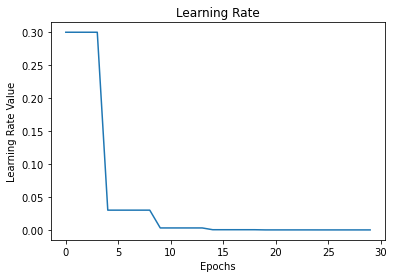

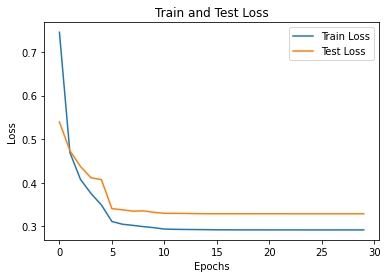

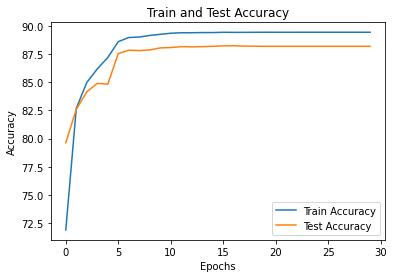

In [54]:
plt.figure()
plt.plot(learning_rates)
plt.title("Learning Rate")
plt.ylabel("Learning Rate Value")
plt.xlabel("Epochs")
plt.show()

plt.figure()
plt.plot(train_loss_epoch)
plt.plot(test_loss_epoch)
plt.title("Train and Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

plt.figure()
plt.plot(acc_train_1)
plt.plot(acc_test_1)
plt.title("Train and Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

In [55]:
train_results = output_results(train_loader, best_val_model, num_classes, data_name='Train')
test_results = output_results(test_loader, best_val_model, num_classes, data_name='Test')
final_result = pd.concat([train_results, test_results], axis=1)
print(final_result)

                         Train       Test
Top One Accuracy     89.435000  88.240000
Top Five Accuracy    99.801667  99.770000
Loss                  0.291821   0.328828
Recall                0.894350   0.882400
Precision             0.894350   0.882400
F1 Score              0.894350   0.882400
Specificity           0.988261   0.986933
Mean Absolute Error   0.000000   0.000000
R2 Score              0.822976   0.803734
